In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, layers
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import re

In [62]:
row_X = pd.read_csv('.\\articles_ko.csv', encoding='utf-8', sep=',')
row_y = pd.read_csv('.\\label_ko.csv', encoding='utf-8', sep=',')

In [84]:
row_X = row_X[row_X.target == 'LG']
row_y = row_y[row_y.index.isin(row_X.index)]

In [86]:
tokenizer = Okt()

In [87]:
words = {}
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.nouns(title)
    for token in tokens:
        words[token] = 1 if token not in words else words[token] + 1

In [88]:
word_to_idx = {}
for key, val in sorted(words.items(), key=lambda x: -x[1]):
    word_to_idx[key] = len(word_to_idx) + 1
    if len(word_to_idx) >= 5000:
        break

In [89]:
X = []
for title in row_X.title:
    title = re.sub(r'[!"#$%&()*+.,-/:;=?@[\]^_`{|}~\'0-9a-zA-Z·…]', '', title)
    title = re.sub(r'[ ]+', '', title)
    tokens = tokenizer.nouns(title)

    raw = []
    for token in tokens:
        num = word_to_idx[token] if token in word_to_idx else 0
        raw.append(num)
    if len(raw) < 30:
        raw += [0] * (30 - len(raw))
    X.append(raw)

In [90]:
X = np.array(X)

In [91]:
row_y.loc[row_y.updown == False, 'updown'] = 0
row_y.loc[row_y.updown == True, 'updown'] = 1
row_y.fillna(1, inplace=True)

In [92]:
y = row_y.updown
y = to_categorical(y)

In [93]:
model = Sequential([
    layers.Embedding(5001, 64),
    layers.LSTM(64, activation='tanh'),
    layers.Dense(2, activation='softmax')
])

In [94]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [95]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', metrics=['accuracy']
)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [98]:
hist = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], validation_data=(X_val, y_val))

Train on 673 samples, validate on 75 samples
Epoch 1/30
480/673 [====================>.........] - ETA: 0s - loss: 0.6969 - accuracy: 0.4979
Epoch 00001: val_accuracy improved from -inf to 0.54667, saving model to best_model.h5
673/673 [==============================] - 2s 3ms/sample - loss: 0.6969 - accuracy: 0.4918 - val_loss: 0.6914 - val_accuracy: 0.5467
Epoch 2/30
480/673 [====================>.........] - ETA: 0s - loss: 0.6933 - accuracy: 0.5063
Epoch 00002: val_accuracy did not improve from 0.54667
673/673 [==============================] - 0s 280us/sample - loss: 0.6933 - accuracy: 0.5067 - val_loss: 0.6914 - val_accuracy: 0.5467
Epoch 3/30
672/673 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4955
Epoch 00003: val_accuracy did not improve from 0.54667
673/673 [==============================] - 0s 286us/sample - loss: 0.6937 - accuracy: 0.4963 - val_loss: 0.6950 - val_accuracy: 0.4533
Epoch 4/30
480/673 [====================>.........] - ETA: 0s - los

In [18]:
from tensorflow.keras.models import load_model

In [99]:
loaded_model = load_model('.\\best_model.h5')
print()
print(f'Test Accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}')


188/188 [==============================] - 0s 891us/sample - loss: 1.1840 - accuracy: 0.5213
Test Accuracy: 0.5213


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

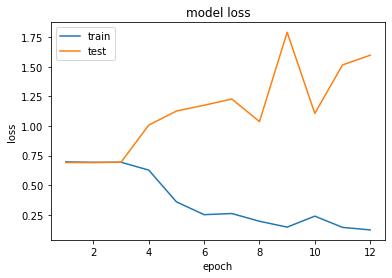

In [100]:
epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'])
plt.plot(epochs, hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()